In [49]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import time
import matplotlib.pyplot as plt

In [4]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2.0
## Load IntAct Raw Data
#### Source (PSI-MITAB): ftp://ftp.ebi.ac.uk/pub/databases/intact/current/psimitab/intact.txt
Downloaded: Dec 8, 2021   
Last Updated: Updated monthly  
Notes for processing: All interactions listed here need to be filtered for human-human interactions. Given the size of the file, we will filter the interactions and save the human-only interactions to a separate file to be loaded to save memory.

In [13]:
IntAct_Raw_v2 = pd.read_csv(wd+'Network_Data_Raw/IntAct/2021-12-00_intact.txt.gz', sep='\t')
print('Raw edge count in IntAct_v2:', len(IntAct_Raw_v2))

Raw edge count in IntAct: 1155104


## Custom Processing of Raw DIP Data

In [18]:
# Columns are the same as the previous dataset
IntAct_Raw_v2.columns

Index(['#ID(s) interactor A', 'ID(s) interactor B', 'Alt. ID(s) interactor A',
       'Alt. ID(s) interactor B', 'Alias(es) interactor A',
       'Alias(es) interactor B', 'Interaction detection method(s)',
       'Publication 1st author(s)', 'Publication Identifier(s)',
       'Taxid interactor A', 'Taxid interactor B', 'Interaction type(s)',
       'Source database(s)', 'Interaction identifier(s)',
       'Confidence value(s)', 'Expansion method(s)',
       'Biological role(s) interactor A', 'Biological role(s) interactor B',
       'Experimental role(s) interactor A',
       'Experimental role(s) interactor B', 'Type(s) interactor A',
       'Type(s) interactor B', 'Xref(s) interactor A', 'Xref(s) interactor B',
       'Interaction Xref(s)', 'Annotation(s) interactor A',
       'Annotation(s) interactor B', 'Interaction annotation(s)',
       'Host organism(s)', 'Interaction parameter(s)', 'Creation date',
       'Update date', 'Checksum(s) interactor A', 'Checksum(s) interactor B',

#### Keep only human-human interactions

In [20]:
# Filter  for only human-human interactions in IntAct
IntAct_Human_Only_v2 = IntAct_Raw_v2[(IntAct_Raw_v2['Taxid interactor A']=='taxid:9606(human)|taxid:9606(Homo sapiens)') & (IntAct_Raw_v2['Taxid interactor B']=='taxid:9606(human)|taxid:9606(Homo sapiens)')]
IntAct_Human_Only_v2 = IntAct_Human_Only_v2.drop_duplicates()
print('Human-Human only edge count in IntAct_v2:', IntAct_Human_Only_v2.shape[0])

Human-Human only edge count in IntAct_v2: 598815


In [22]:
Human_IntAct_Genes_v2 = list(set(IntAct_Human_Only_v2['#ID(s) interactor A']).union(set(IntAct_Human_Only_v2['ID(s) interactor B'])))

## Convert Genes

In [26]:
# Construct list of genes to be submitted to MyGene.Info API (remove all genes with 'intact' prefix)
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(Human_IntAct_Genes_v2, exclude_prefixes=['intact'])

28262 Valid Query Genes
2152 Invalid Query Genes


In [29]:
# Set scopes (gene naming systems to search)
scopes = "uniprot"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list_v2 = gct.query_batch(query_string_v2, scopes=scopes, fields=fields)


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]

28537 Matched query results
Batch query complete: 21.53 seconds


In [30]:
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(match_list_v2, valid_genes_v2)

Queries without full matching results found: 9651

192 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 20.14 seconds


## Construct Converted Network

In [37]:
query_edgelist_v2 = IntAct_Human_Only_v2[['#ID(s) interactor A', 'ID(s) interactor B']].drop_duplicates().values.tolist()

In [38]:
# Original = 5864/161035
# Filter query edgelist of interactions with invalid genes
query_edgelist_filt_v2 = gct.filter_query_edgelist(query_edgelist_v2, invalid_genes_v2)


11362 / 360056 edges with invalid nodes removed


In [39]:
# Format edge list by removing 'uniprot:' prefix from all interactors
query_edgelist_filt_fmt_v2 = [[gct.get_identifier_without_prefix(edge[0]), gct.get_identifier_without_prefix(edge[1])] for edge in query_edgelist_filt_v2]

In [40]:
# Convert network edge list to symbol
IntAct_edgelist_symbol_v2 = gct.convert_edgelist(query_edgelist_filt_fmt_v2, query_to_symbol_v2)

In [41]:
# Filter converted edge list
IntAct_edgelist_symbol_filt_v2 = gct.filter_converted_edgelist(IntAct_edgelist_symbol_v2)

348694 input edges
2167 self-edges removed
83087 edges with un-mapped genes removed
1302 duplicate edges removed
Edge list filtered: 0.1 seconds
262138 Edges remaining


In [42]:
# Save filtered, converted edge list to file
gct.write_edgelist(IntAct_edgelist_symbol_filt_v2, wd+'/Processed_Data/Network_SIFs_Symbol/IntAct_Symbol_2021.sif')

Edge list saved: 0.29 seconds


# Version 1.0 (Original)
## Load IntAct Raw Data
#### Source (PSI-MITAB): ftp://ftp.ebi.ac.uk/pub/databases/intact/current/psimitab/intact.txt
Downloaded: June 15, 2017   
Last Updated: June 05, 2017  
Notes for processing: All interactions listed here need to be filtered for human-human interactions. Given the size of the file, we will filter the interactions and save the human-only interactions to a separate file to be loaded to save memory.

In [10]:
IntAct_Raw = pd.read_csv(wd+'Network_Data_Raw/IntAct/2016-09-08_intact.txt.gz', sep='\t', low_memory=False)
print('Raw edge count in IntAct:', len(IntAct_Raw))

/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Raw edge count in IntAct: 653104


## Custom Processing of Raw DIP Data

In [14]:
IntAct_Raw.columns

Index(['#ID(s) interactor A', 'ID(s) interactor B', 'Alt. ID(s) interactor A',
       'Alt. ID(s) interactor B', 'Alias(es) interactor A',
       'Alias(es) interactor B', 'Interaction detection method(s)',
       'Publication 1st author(s)', 'Publication Identifier(s)',
       'Taxid interactor A', 'Taxid interactor B', 'Interaction type(s)',
       'Source database(s)', 'Interaction identifier(s)',
       'Confidence value(s)', 'Expansion method(s)',
       'Biological role(s) interactor A', 'Biological role(s) interactor B',
       'Experimental role(s) interactor A',
       'Experimental role(s) interactor B', 'Type(s) interactor A',
       'Type(s) interactor B', 'Xref(s) interactor A', 'Xref(s) interactor B',
       'Interaction Xref(s)', 'Annotation(s) interactor A',
       'Annotation(s) interactor B', 'Interaction annotation(s)',
       'Host organism(s)', 'Interaction parameter(s)', 'Creation date',
       'Update date', 'Checksum(s) interactor A', 'Checksum(s) interactor B',

#### Keep only human-human interactions

In [19]:
# Filter  for only human-human interactions in IntAct
IntAct_Human_Only = IntAct_Raw[(IntAct_Raw['Taxid interactor A']=='taxid:9606(human)|taxid:9606(Homo sapiens)') & (IntAct_Raw['Taxid interactor B']=='taxid:9606(human)|taxid:9606(Homo sapiens)')]
IntAct_Human_Only = IntAct_Human_Only.drop_duplicates()
print('Human-Human only edge count in IntAct:', IntAct_Human_Only.shape[0])

Human-Human only edge count in IntAct: 247565


In [21]:
Human_IntAct_Genes = list(set(IntAct_Human_Only['#ID(s) interactor A']).union(set(IntAct_Human_Only['ID(s) interactor B'])))

## Convert Genes

In [23]:
# Construct list of genes to be submitted to MyGene.Info API (remove all genes with 'intact' prefix)
query_string, valid_genes, invalid_genes = gct.query_constructor(Human_IntAct_Genes, exclude_prefixes=['intact'])

19143 Valid Query Genes
1162 Invalid Query Genes


In [25]:
# Original 19368 matched query results
# Set scopes (gene naming systems to search)
scopes = "uniprot"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list = gct.query_batch(query_string, scopes=scopes, fields=fields)
print(len(match_list), 'Matched query results')

100%|██████████| 20/20 [00:16<00:00,  1.24it/s]

19331 Matched query results
Batch query complete: 16.28 seconds
19331 Matched query results


In [28]:
#Original unmatched = 4329

match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(match_list, valid_genes)

Queries without full matching results found: 4441

134 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 9.74 seconds


## Construct Converted Network

In [31]:
query_edgelist = IntAct_Human_Only[['#ID(s) interactor A', 'ID(s) interactor B']].drop_duplicates().values.tolist()

In [32]:
# Original = 5864/161035
# Filter query edgelist of interactions with invalid genes
query_edgelist_filt = gct.filter_query_edgelist(query_edgelist, invalid_genes)


5864 / 161035 edges with invalid nodes removed


In [33]:
# Format edge list by removing 'uniprot:' prefix from all interactors
query_edgelist_filt_fmt = [[gct.get_identifier_without_prefix(edge[0]), gct.get_identifier_without_prefix(edge[1])] for edge in query_edgelist_filt]

In [34]:
# Convert network edge list to symbol
IntAct_edgelist_symbol = gct.convert_edgelist(query_edgelist_filt_fmt, query_to_symbol)

In [35]:
## Original stats##
#155171 input edges
#3236 self-edges removed
#20662 edges with un-mapped genes removed
#16701 duplicate edges removed
#Edge list filtered: 0.43 seconds
#114572 Edges remaining

# Filter converted edge list
IntAct_edgelist_symbol_filt = gct.filter_converted_edgelist(IntAct_edgelist_symbol)

155171 input edges
1565 self-edges removed
23439 edges with un-mapped genes removed
654 duplicate edges removed
Edge list filtered: 0.06 seconds
129513 Edges remaining


In [36]:
# Save filtered, converted edge list to file
gct.write_edgelist(IntAct_edgelist_symbol_filt, wd+'/Processed_Data/Network_SIFs_Symbol/IntAct_Symbol_2016.sif')

Edge list saved: 0.26 seconds


# Changes
* No changes identified in structure of data
* Minor changes when re-running the original dataset due to updated symbol database being queried

In [50]:
stats = pd.DataFrame({"v1":[653104, 247565, 129513], 
                           "v2":[1155104, 598815, 262138]},
                           index=["input", "human_human", "filtered"])

In [51]:
nodes_v1 = set(IntAct_Human_Only["#ID(s) interactor A"].values).union(set(IntAct_Human_Only["ID(s) interactor B"].values))
nodes_v2 = set(IntAct_Human_Only_v2["#ID(s) interactor A"].values).union(set(IntAct_Human_Only_v2["ID(s) interactor B"].values))
new_nodes = v2_nodes.difference(v1_nodes)

Text(0, 0.5, 'Number of nodes')

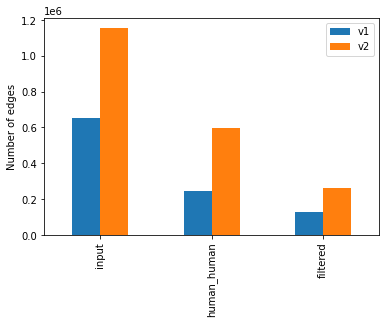

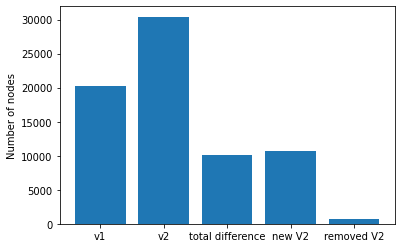

In [52]:
stats.plot.bar(ylabel="Number of edges")
plt.figure()
plt.bar(["v1", "v2", "total difference", "new V2", "removed V2"], [len(nodes_v1), len(nodes_v2), len(nodes_v2)-len(nodes_v1),
                                                           len(nodes_v2.difference(nodes_v1)), len(nodes_v1.difference(nodes_v2))])
plt.ylabel("Number of nodes")